# Risk Analytics Engine - Full Walkthrough

This notebook explains:
- How synthetic data is generated
- How returns are computed
- How the portfolio is created
- How PnL is simulated
- How VaR & ES models work
- How PCA factors are extracted
- How stress tests are applied
- How results and plots are interpreted

In [10]:
import os
os.chdir("/Users/deborahakintoye/GitHub/quant-strat-lab/projects/31_risk_analytics_engine")

In [11]:
## 1. Load Data

from src.data.load_data import load_prices, load_returns

prices = load_prices()
returns = load_returns("log")

prices.head(), returns.head()


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


(              EURUSD      USDJPY    UST10Y        CRUD       SPX500
 2021-01-01  1.150000  110.000000  4.200000   85.080000  4500.000000
 2021-01-04  0.000673   13.993977  8.370248  139.920740  7872.992573
 2021-01-05  0.000621   14.808470  7.918330  131.299871  8566.725361
 2021-01-06  0.000524   17.070955  8.598645  157.363574  9140.595154
 2021-01-07  0.000545   15.185268  7.909543  152.519609  9554.396958,
               EURUSD    USDJPY    UST10Y      CRUD    SPX500
 2021-01-04 -7.444151 -2.061853  0.689599  0.497484  0.559361
 2021-01-05 -0.078993  0.056572 -0.055503 -0.063592  0.084447
 2021-01-06 -0.169927  0.142179  0.082424  0.181075  0.064840
 2021-01-07  0.038961 -0.117053 -0.083535 -0.031266  0.044276
 2021-01-08  0.063815  0.019484  0.104512  0.135297 -0.014014)

In [12]:
## 2. Portfolio Construction

from src.backtest.portfolio_sim import (
    generate_random_weights,
    compute_portfolio_pnl,
    compute_dv01,
    compute_factor_exposures
)

weights = generate_random_weights(returns.shape[1])
pnl = compute_portfolio_pnl(returns, weights)
dv01 = compute_dv01(prices["UST10Y"])
factors = compute_factor_exposures(returns, weights)

weights, pnl.head(), dv01.head(), factors


(array([ 0.06110532, -0.20854938,  0.15048897,  0.18861268, -0.39124365]),
 2021-01-04   -0.046116
 2021-01-05   -0.070011
 2021-01-06   -0.018846
 2021-01-07   -0.008999
 2021-01-08    0.046566
 Name: PnL, dtype: float64,
 2021-01-01    0.003780
 2021-01-04    0.007533
 2021-01-05    0.007126
 2021-01-06    0.007739
 2021-01-07    0.007119
 Name: UST10Y, dtype: float64,
 array([-0.00660924, -0.12550515,  0.33637156,  0.18944397, -0.30608807]))

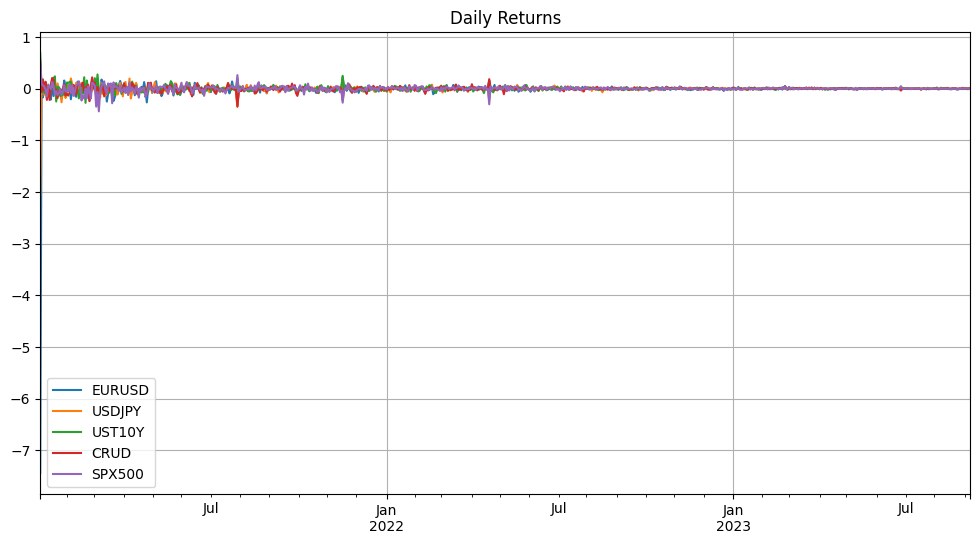

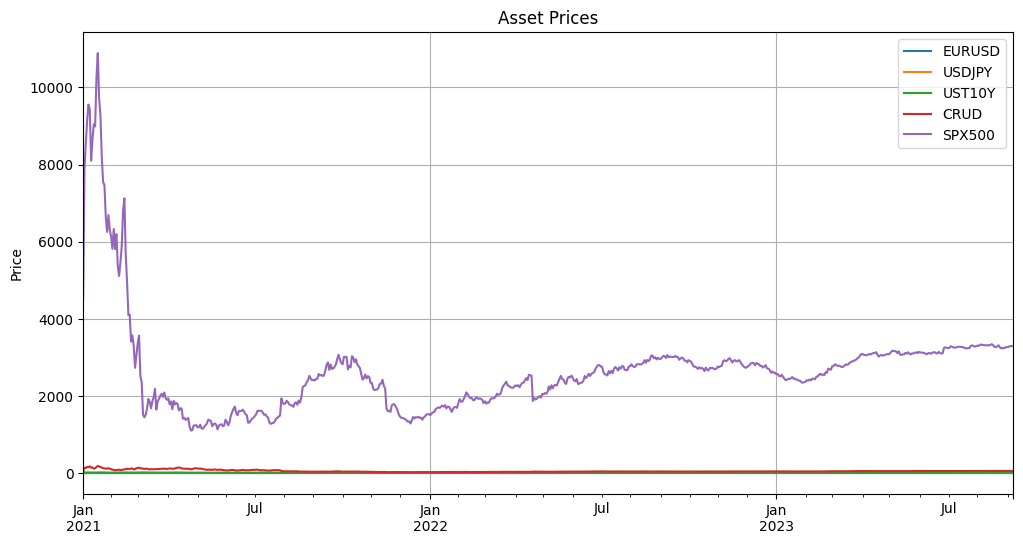

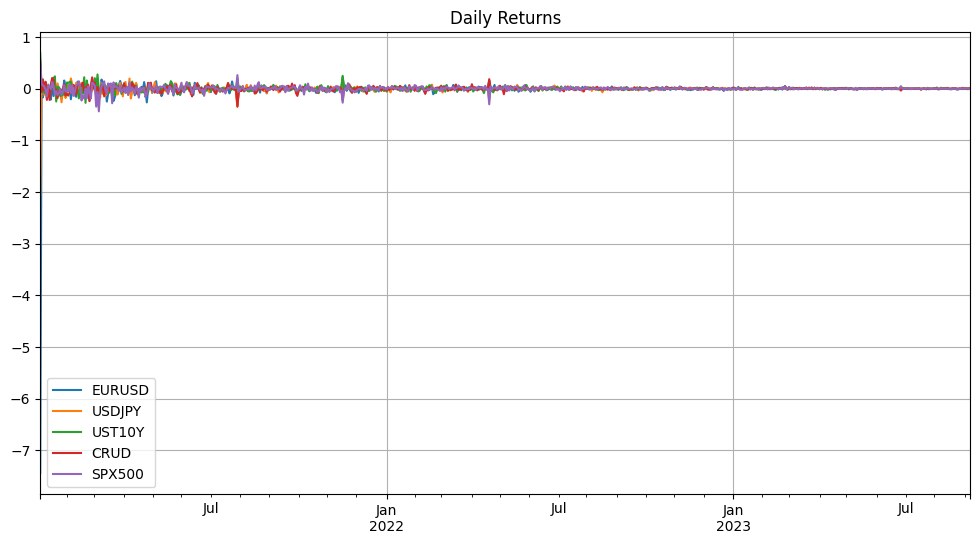

In [ ]:
## 3. Plot Prices & Returns

from src.utlis.plotting import plot_prices, plot_returns

plot_prices(prices)
plot_returns(returns)


In [17]:
## 4. VaR and Expected Shortfall

from src.models.var import historical_var, parametric_var_norm, monte_carlo_var
from src.models.es import historical_es

hist_var_99 = historical_var(pnl, 0.99)
para_var_99 = parametric_var_norm(pnl.mean(), pnl.std(), 0.99)
mc_var_99, dist = monte_carlo_var(returns.mean(), returns.cov(), 20000, 0.99)
hist_es_99 = historical_es(pnl)

hist_var_99, para_var_99, mc_var_99, hist_es_99


(-0.05682308659910189,
 -0.052061624398898006,
 -0.7840899794882238,
 -0.07451026738118639)

array([0.90769736, 0.03832123, 0.02174275, 0.01719384, 0.01504482])

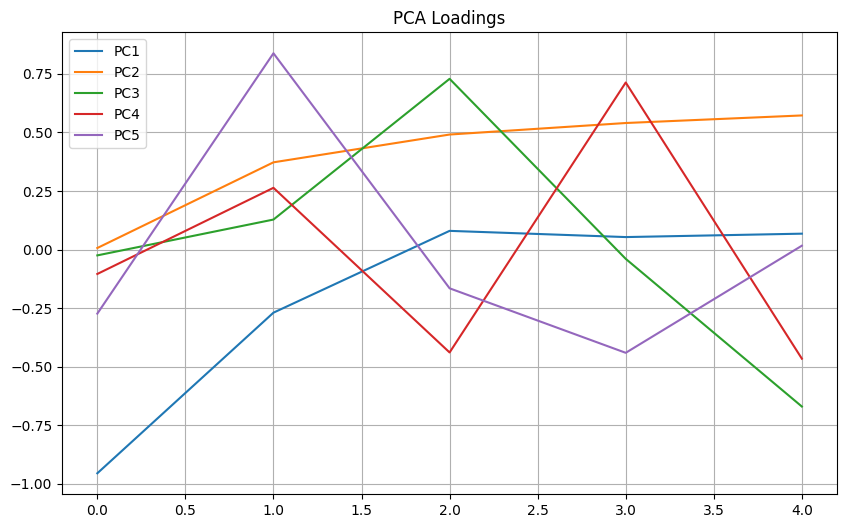

In [ ]:
## 5. PCA Factor Analysis

from src.models.pca import run_pca
from src.utlis.plotting import plot_pca_loadings

eigvals, eigvecs, explained = run_pca(returns)
plot_pca_loadings(eigvecs)

explained


In [30]:
## 6. Stress Testing

from src.models.stress_tests import (
    stress_return_shock,
    stress_vol_shock,
    stress_corr_break,
    attribute_scenario_losses
)

# Return Shock
ret_shocked = stress_return_shock(returns, shock_size=-0.04)

vol_shocked = stress_vol_shock(returns, multiplier=2.0)

from src.utlis.math_utils import cov_to_corr
corr = cov_to_corr(returns.cov())
corr_shocked = stress_corr_break(corr, break_factor=0.5)

loss_contrib = attribute_scenario_losses(weights, ret_shocked)
loss_contrib



InvalidIndexError: 

In [ ]:
## 7. Stress Plot

from src.utlis.plotting import plot_stress_losses
plot_stress_losses(loss_contrib, labels=returns.columns)


NameError: name 'loss_contrib' is not defined

In [34]:
## 8. Final Summary


import pandas as pd

summary = pd.DataFrame({
    "Historical VaR 99%": [hist_var_99],
    "Parametric VaR 99%": [para_var_99],
    "Monte Carlo VaR 99%": [mc_var_99],
    "Historical ES 99%": [hist_es_99],
    "Mean DV01": [dv01.mean()],
})

summary


,Historical VaR 99%,Parametric VaR 99%,Monte Carlo VaR 99%,Historical ES 99%,Mean DV01
0,-0.056823,-0.052062,-0.78409,-0.07451,0.008016
